<a href="https://colab.research.google.com/github/ian-shade/Autotrader-Cars-Price-Predictions-ML/blob/main/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries for data analysis and machine learning
import pandas as pd                          # Data manipulation and analysis
from google.colab import drive               # Access Google Drive files
import seaborn as sns                        # Statistical data visualization
import matplotlib.pyplot as plt              # Plotting library
from sklearn.preprocessing import OneHotEncoder  # Categorical encoding
from sklearn.model_selection import train_test_split  # Train/test splitting
import numpy as np                           # Numerical computing

In [ ]:
# Mount Google Drive to access the dataset
drive.mount('/content/drive')

In [ ]:
# Load the AutoTrader car adverts dataset
file_path = '/content/drive/MyDrive/Colab/adverts.csv'
df = pd.read_csv(file_path)

# 1. Data/Domain Understanding and Exploration

This section focuses on understanding the dataset, identifying data types, distributions, and exploring relationships between features and the target variable (price).

## 1.1 Initial Data Inspection

**Objective**: Examine the first few rows, data types, and overall structure of the dataset to understand what we're working with.

In [ ]:
# Display first 3 rows to get a preview of the data structure and feature values
df.head(3)

In [ ]:
# Get comprehensive information about the dataset:
# - Total number of entries (rows)
# - Number of columns
# - Data types of each feature
# - Non-null counts (to identify missing values)
# - Memory usage
df.info()

In [ ]:
# Create a detailed summary of missing values and unique value counts for each feature
# This helps identify:
# - Features with high cardinality (many unique values)
# - Features with missing data that need imputation or removal
# - Data quality issues
variables = pd.DataFrame(columns=['Variable','Number of unique values','Number of nulls'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].isnull().sum()]

variables

## 1.2 Target Variable Analysis - Price Distribution

**Objective**: Understand the distribution of our target variable (price) to determine if transformations are needed.

## 1.3 Data Quality Improvements and Feature Engineering

**Objective**: Fix obvious data issues and create more meaningful features for analysis.

### Feature Engineering: Creating Car Age from Year of Registration

**Rationale**:
- Car age is more intuitive and directly correlates with depreciation than year of registration
- NEW cars have NaN values for `year_of_registration` - we assume these are 2023 models
- The assumption is based on the latest USED car being from 2021, so NEW cars are likely 2023 models (2 years newer)

# Impute missing year_of_registration values for NEW cars as 2023
df['year_of_registration'] = df['year_of_registration'].fillna(2023)

# Engineer 'age' feature: age = current year (2023) - year of registration
# Older cars have higher age values, which inversely correlates with price
df['age'] = 2023 - df['year_of_registration']

# Drop original 'year_of_registration' column as it's been replaced by 'age'
df = df.drop('year_of_registration', axis=1)

In [ ]:
# Drop irrelevant or redundant features:
# - 'reg_code': High missing values (7.9%) and low predictive power for price
# - 'standard_model': Too many unique values (1,168) - would create sparse one-hot encoding
#                     Brand information is captured in 'standard_make' and 'brand_prestige'
# - 'public_reference': Unique identifier with no predictive value
df = df.drop('reg_code', axis=1)
df = df.drop('standard_model', axis=1)
df = df.drop('public_reference', axis=1)

## 1.4 Target Variable Distribution Analysis

# Visualize the distribution of the target variable (price)
# Compare original scale vs. log-transformed scale

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot 1: Original price distribution
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original Scale)')
axes[0].axvline(df['price'].median(), color='r', linestyle='--',
                label=f'Median: £{df["price"].median():,.0f}')
axes[0].legend()

# Plot 2: Log-transformed price distribution
# Log transformation helps normalize right-skewed data for linear models
axes[1].hist(np.log1p(df['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.tight_layout()
plt.show()

# Calculate skewness and kurtosis to quantify distribution shape
print(f"\nSkewness: {df['price'].skew():.3f} (high positive skew)")
print(f"Kurtosis: {df['price'].kurtosis():.3f}")
print("\n**Interpretation:** Heavy right skew indicates most cars are lower-priced with")
print("luxury outliers. Log transformation normalizes this for linear models.")

In [ ]:
# Remove extreme price outliers (super/luxury cars above £350,000)
# These vehicles operate in a different market segment with different valuation logic
price_cap = 350000

df_clean = df[df['price'] < price_cap].copy()

# Report data loss from outlier removal
lost_data = len(df) - len(df_clean)
print(f"Removed {lost_data} rows ({(lost_data/len(df))*100:.2f}%) as price outliers.")
df = df_clean

In [ ]:
# Visualize price distribution after removing extreme outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Original price distribution (after outlier removal)
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution After Outlier Removal')
axes[0].axvline(df['price'].median(), color='r', linestyle='--',
                label=f'Median: £{df["price"].median():,.0f}')
axes[0].legend()

# Log-transformed distribution
axes[1].hist(np.log1p(df['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.tight_layout()
plt.show()

## 1.5 Numeric Features Analysis and Outlier Detection

**Objective**: Analyze numeric features (age, mileage) and identify outliers that may negatively impact model performance.

**Rationale for Outlier Removal**:

**Removing Old/Vintage Cars**:
- While data points such as a 1969 Land Rover Series II were identified as valid (not noise), they are removed as outliers
- Vintage vehicles follow a different valuation logic (appreciating assets) compared to standard modern vehicles
- Including them would introduce non-linearity that could degrade Linear Regression performance
- Any car before 1886 is definitively noise (first car ever made was in 1886)

**Removing High Mileage Vehicles**:
- Some cars have unrealistic mileage values exceeding records for the most driven car in the world
- Very high mileage vehicles (e.g., taxis) exist but are limited in the dataset
- Including them provides minimal benefit as taxi adverts are rare, especially after Uber's rise
- These outliers can distort the model's understanding of the mileage-price relationship

In [ ]:
# Define numeric features for analysis
num_feat = ['age', 'mileage']

# Visualize the relationship between numeric features and price (before outlier removal)
# This helps identify non-linear relationships and extreme values
fig, axs = plt.subplots(nrows=1, ncols=len(num_feat), figsize=(11,3))
for i in range(len(num_feat)):
    sns.scatterplot(data=df, x=num_feat[i-1], y='price', alpha=0.5, ax=axs[i-1])

In [ ]:
# Define outlier thresholds based on domain knowledge
mileage_cap = 300000  # Exclude taxis and erroneous high mileage entries
age_cap = 33          # Exclude vintage cars (keep cars from 1990 onwards)

# Filter dataset to remove outliers
df_clean = df[
    (df['mileage'] < mileage_cap) &
    (df['age'] <= age_cap)
].copy()

# Report data loss from outlier removal
lost_data = len(df) - len(df_clean)
print(f"Removed {lost_data} rows ({(lost_data/len(df))*100:.2f}%) as outliers.")
df = df_clean

In [ ]:
# Visualize relationships after outlier removal
# Should show cleaner, more linear relationships
fig, axs = plt.subplots(nrows=1, ncols=len(num_feat), figsize=(11,3))
for i in range(len(num_feat)):
    sns.scatterplot(data=df, x=num_feat[i-1], y='price', alpha=0.5, ax=axs[i-1])

## 1.6 Feature Engineering: Brand Prestige Classification

**Objective**: Create a `brand_prestige` feature to capture the luxury tier of car brands, which is a strong price predictor.

**Approach**: Map each brand to a prestige class (1-5) based on typical market positioning and average price points:
- **Class 5**: Exotic/Hypercar (£150k+) - Ferrari, Lamborghini, McLaren, Bugatti, Pagani
- **Class 4**: Ultra-Luxury (£95k+) - Bentley, Rolls-Royce, Maybach, Daimler
- **Class 3**: Luxury (£40k+) - Jaguar, Land Rover, Porsche, Maserati, Aston Martin
- **Class 2**: Premium/Near-Luxury (£20k+) - Audi, BMW, Mercedes-Benz, Volvo, Lexus
- **Class 1**: Mass Market/Budget (£10k+) - Ford, Vauxhall, Kia, Hyundai, Nissan, Toyota

In [ ]:
# Function to classify car brands into prestige tiers
def get_brand_prestige_class(brand):
    """
    Maps car brands to prestige classes (1-5) based on market positioning.
    
    Args:
        brand (str): Car manufacturer name
    
    Returns:
        int: Prestige class from 1 (mass market) to 5 (exotic)
    """
    
    prestige_map = {
        # Class 5: Exotic/Hypercar (£150k+)
        'Ferrari': 5, 'Lamborghini': 5, 'McLaren': 5, 'Bugatti': 5, 'Pagani': 5,

        # Class 4: Ultra-Luxury (£95k)
        'Bentley': 4, 'Rolls-Royce': 4, 'Maybach': 4, 'Daimler': 4, 'BAC': 4,

        # Class 3: Luxury (£40k)
        'Jaguar': 3, 'Land Rover': 3, 'Porsche': 3, 'Maserati': 3, 'Aston Martin': 3, 'Lotus': 3, 'TVR': 3,
        'Morgan': 3, 'Caterham': 3, 'Noble': 3, 'Ariel': 3, 'Alpine': 3, 'Corvette': 3, 'Hummer': 3, 'Radical': 3,
        'Ultima': 3, 'AC': 3, 'Bristol': 3, 'Jensen': 3, 'Triumph': 3,

        # Class 2: Premium/Near-Luxury (£20k)
        'Audi': 2, 'BMW': 2, 'Mercedes-Benz': 2, 'Volkswagen': 2, 'MINI': 2, 'Volvo': 2, 'Lexus': 2,
        'Alfa Romeo': 2, 'Subaru': 2, 'Infiniti': 2, 'Tesla': 2, 'Abarth': 2, 'Cadillac': 2, 'Lincoln': 2,
        'Saab': 2, 'Lancia': 2, 'Chrysler': 2, 'Buick': 2, 'Westfield': 2, 'Zenos': 2,

        # Class 1: Budget + Mass Market (£10k) - ALL OTHERS

        # Budget brands
        'Dacia': 1, 'Perodua': 1, 'Proton': 1, 'SsangYong': 1, 'Daewoo': 1, 'Great Wall': 1, 'Rover': 1,
        'MG': 1, 'Suzuki': 1, 'Daihatsu': 1, 'Datsun': 1, 'Aixam': 1, 'Reliant': 1,
        # Mass market brands
        'Vauxhall': 1, 'SKODA': 1, 'SEAT': 1, 'Peugeot': 1, 'Citroen': 1, 'Renault': 1, 'Fiat': 1, 'Kia': 1,
        'Hyundai': 1, 'Nissan': 1, 'Toyota': 1, 'Honda': 1, 'Mazda': 1, 'Mitsubishi': 1, 'Ford': 1,
        'Chevrolet': 1, 'Opel': 1, 'Smart': 1, 'DS AUTOMOBILES': 1, 'CUPRA': 1, 'Jeep': 1, 'Dodge': 1,
        'GMC': 1, 'Isuzu': 1, 'Pontiac': 1, 'Plymouth': 1, 'Holden': 1, 'International': 1,
        # Commercial/Taxi
        'London Taxis International': 1, 'LEVC': 1, 'Carbodies': 1, 'Iveco': 1,
        # Classic/Kit cars (lower value)
        'Panther': 1, 'Replica': 1, 'Custom Vehicle': 1, 'Dax': 1, 'Tiger': 1, 'Pilgrim': 1, 'Mev': 1,
        'Beauford': 1, 'Sebring': 1, 'Gentry': 1, 'AK': 1, 'Mitsuoka': 1, 'Austin': 1, 'Morris': 1,
        'Leyland': 1, 'Wolseley': 1,
    }

    # Return mapped value or default to 1 (mass market) for unknown brands
    return prestige_map.get(brand, 1)

In [ ]:
# Apply the prestige classification to create new feature
df['brand_prestige'] = df['standard_make'].apply(get_brand_prestige_class)

# Validate the prestige classification by examining price statistics per class
# Expected: higher prestige → higher average/median price
print(df.groupby('brand_prestige')['price'].agg(['count', 'mean', 'median']).round(0))

In [ ]:
# Visualize the distribution of cars across prestige classes
plt.figure(figsize=(8, 5))
percentages_prestige = df['brand_prestige'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
percentages_prestige.columns = ['brand_prestige', 'percent']
sns.barplot(data=percentages_prestige, x='brand_prestige', y='percent', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Distribution of Brand Prestige Classes')
plt.xlabel('Brand Prestige Class (1=Mass Market, 5=Exotic)')
plt.ylabel('Percentage of Dataset (%)')
plt.xticks(rotation=0)

# Add percentage labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize average price by brand prestige class
plt.figure(figsize=(8, 5))
mean_price_prestige = df.groupby('brand_prestige')['price'].mean().reset_index()
sns.barplot(data=mean_price_prestige, x='brand_prestige', y='price', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Average Price by Brand Prestige Class')
plt.xlabel('Brand Prestige Class (1=Mass Market, 5=Exotic)')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=0)

# Add price labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='£%.0f')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 1.7 Categorical Features Analysis and Dimensionality Reduction

**Objective**: Analyze categorical features and reduce high cardinality to prevent sparse encoding and improve model performance.

**Strategy for Dimensionality Reduction**:

Currently many categorical features have high cardinality with very little representation in lower-frequency categories. This approach addresses this:

1. **Keep Top N Categories**: For each categorical feature, retain only the most frequent categories
2. **Group Remaining as "Other"**: All categories not in the top N are combined into a single "Other" category
3. **The "Tail Effect"**: The new "Other" category may sometimes be more represented than individual brands - this is expected and beneficial, especially for features like `standard_make` where many small brands collectively form a significant portion

**Planned Reductions**:
- Keep top 20 Brands (standard_make)
- Keep top 10 Colors (standard_colour)
- Keep top 8 Body Types (body_type)
- Keep top 4 Fuel Types (Petrol, Diesel, Hybrid, Electric)
- Everything else becomes "Other"

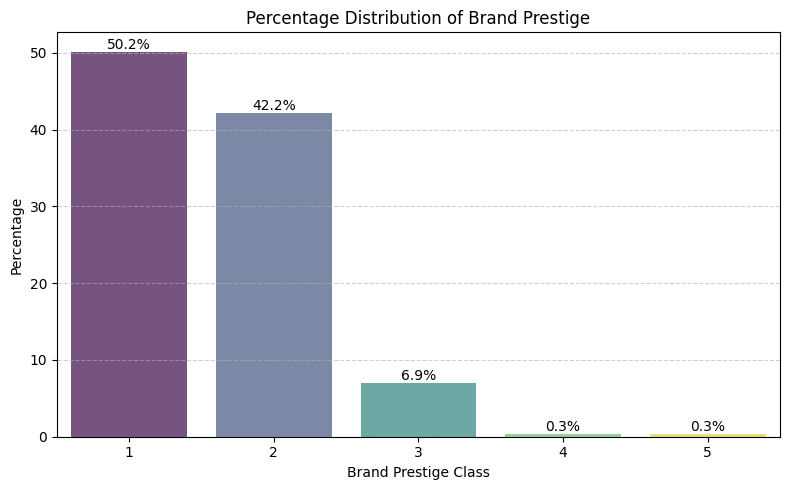

In [144]:
# 1. Percentage Distribution for brand_prestige
plt.figure(figsize=(8, 5))
percentages_prestige = df['brand_prestige'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
percentages_prestige.columns = ['brand_prestige', 'percent']
sns.barplot(data=percentages_prestige, x='brand_prestige', y='percent', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Percentage Distribution of Brand Prestige')
plt.xlabel('Brand Prestige Class')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Check the balance of the crossover feature
# Convert boolean to integer for easier analysis
df['crossover_car_and_van'] = df['crossover_car_and_van'].astype(int)
df['crossover_car_and_van'].value_counts(normalize=True)

# Drop 'crossover_car_and_van' due to near-zero variance
# Less than 0.5% positive class provides insufficient signal for prediction
# Including it adds noise without predictive value
df.drop(columns=['crossover_car_and_van'], inplace=True, errors='ignore')

# Define categorical features for analysis
categorical_feat = ['standard_colour', 'standard_make',
                    'vehicle_condition', 'body_type','fuel_type']

def printCountCategorical():
    """
    Visualize the percentage distribution of all categorical features.
    This helps identify:
    - Imbalanced categories
    - Rare categories that should be grouped as "Other"
    - The overall composition of each categorical feature
    """
    num_cols = len(categorical_feat)
    fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(5 * num_cols, 6))
    axs = axs.flatten()

    for i in range(len(categorical_feat)):
        # Calculate percentage for each category
        percentages = df[categorical_feat[i]].value_counts(normalize=True).mul(100).rename('percent').reset_index()
        percentages.columns = [categorical_feat[i], 'percent']

        # Create bar plot
        sns.barplot(data=percentages, x=categorical_feat[i], y='percent', alpha=0.5, ax=axs[i])
        axs[i].set_title(f'Distribution of {categorical_feat[i]}')
        axs[i].set_ylabel('Percentage (%)')
        axs[i].set_xticks(axs[i].get_xticks())
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

        # Add percentage labels on bars
        for container in axs[i].containers:
            axs[i].bar_label(container, fmt='%.1f%%')

    plt.tight_layout()
    plt.show()

# Visualize current distribution (before dimensionality reduction)
printCountCategorical()

In [ ]:
def clean_categorical(df, column, top_n=10):
    """
    Reduce cardinality of a categorical feature by keeping top N categories
    and grouping the rest as 'Other'.
    
    Args:
        df: DataFrame to modify (in-place)
        column: Name of the categorical column
        top_n: Number of top categories to keep
    """
    # Find the top N most frequent categories
    top_categories = df[column].value_counts().nlargest(top_n).index

    # Replace less frequent categories with 'Other'
    df[column] = df[column].where(df[column].isin(top_categories), other='Other')

    print(f"Cleaned '{column}': now has {df[column].nunique()} unique categories.")

In [ ]:
# Apply dimensionality reduction to categorical features
clean_categorical(df, 'standard_colour', top_n=10)  # Keep top 10 Colors
clean_categorical(df, 'body_type', top_n=8)         # Keep top 8 Body Types
clean_categorical(df, 'fuel_type', top_n=4)         # Keep top 4 Fuel Types
clean_categorical(df, 'standard_make', top_n=20)    # Keep top 20 Brands

In [ ]:
# Visualize distributions after dimensionality reduction
# Should show cleaner distributions with "Other" category
printCountCategorical()

## 1.8 Analysis of Predictive Power of Features

**Objective**: Identify which features have the strongest relationship with price to guide feature selection and model building.

In [ ]:
# NUMERIC FEATURES: Correlation Analysis
# Calculate correlation matrix for all numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

# Focus on correlation with price (our target variable)
price_correlation = correlation_matrix['price'].sort_values(ascending=False)

# Visualize correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Numeric Features vs Price')
plt.tight_layout()
plt.show()

print("\n--- Correlation with Price (Target Variable) ---")
print(price_correlation)


# VISUAL ANALYSIS: Scatter plots of top numeric predictors vs price
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Top numeric predictors based on correlation
top_features = ['age', 'mileage', 'price']

# Scatter plots for age and mileage
for i, feature in enumerate(top_features[:-1]):  # Exclude price itself
    axes[i].scatter(df[feature], df['price'], alpha=0.3, s=10)
    axes[i].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i].set_ylabel('Price (£)', fontsize=12)
    axes[i].set_title(f'{feature.capitalize()} vs Price\n(Correlation: {df[feature].corr(df["price"]):.3f})',
                      fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Add price distribution for context
axes[2].hist(df['price'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('Price (£)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Price Distribution', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# CATEGORICAL FEATURES: Mean Price by Category (Predictive Power Analysis)
categorical_features = ['brand_prestige', 'body_type', 'fuel_type', 'vehicle_condition']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    # Calculate mean price and count per category
    feature_price = df.groupby(feature)['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)

    # Keep only top 10 categories for readability
    top_10 = feature_price.head(10)

    # Create horizontal bar chart
    axes[i].barh(range(len(top_10)), top_10['mean'], color='steelblue', alpha=0.7)
    axes[i].set_yticks(range(len(top_10)))
    axes[i].set_yticklabels(top_10.index)
    axes[i].set_xlabel('Average Price (£)', fontsize=11)
    axes[i].set_title(f'Mean Price by {feature} (Top 10)', fontsize=12, fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for j, v in enumerate(top_10['mean']):
        axes[i].text(v + 500, j, f'£{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Statistical measure: Variance Ratio (high = strong predictor)
print("\n--- Predictive Power: Between-Group Variance Ratio ---")
print("Higher ratio = more predictive power\n")
for feature in categorical_features:
    grouped = df.groupby(feature)['price']
    between_var = grouped.mean().var()  # Variance of group means
    within_var = df['price'].var()       # Total variance
    variance_ratio = between_var / within_var

    print(f"{feature:20s}: {variance_ratio:.4f}")


# 2. Data Processing for Machine Learning

This section prepares the cleaned and explored data for machine learning by applying transformations, encoding, and splitting.

## 2.1 One-Hot Encoding for Categorical Features

**Objective**: Convert categorical variables into numeric format suitable for machine learning algorithms.

**Approach**: Use one-hot encoding to create binary columns for each category.

In [ ]:
# Check dataset shape before encoding
df.shape

# Display current features before encoding
df.keys()

In [ ]:
# Apply one-hot encoding to all categorical features
# This converts each category into a separate binary column (0 or 1)
ohe = OneHotEncoder(handle_unknown='ignore')

# pandas.get_dummies automatically identifies and encodes object-type columns
df = pd.get_dummies(data=df, dtype=int)

# Check new shape after encoding
# Expected: More columns due to categorical expansion
df.shape

In [ ]:
# Alternative approach using Pipeline (commented out)
# This approach combines imputation, scaling, and encoding in a single pipeline
# Useful for production deployment but less transparent for learning

# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

# numeric_cols = ['mileage', 'age', 'brand_prestige']
# categorical_cols = ['standard_colour', 'standard_make',
#                     'vehicle_condition', 'body_type','fuel_type']

# numeric_transformer = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler(with_mean=False))  # IMPORTANT for sparse matrices
# ])

# categorical_transformer = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=50, sparse_output=True))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_cols),
#         ("cat", categorical_transformer, categorical_cols),
#     ],
#     remainder="drop",
#     sparse_threshold=0.3
# )

In [ ]:
# Display all features after one-hot encoding
# Notice the expanded feature set with binary columns for each category
df.keys()

## 2.2 Avoiding Multicollinearity (Dummy Variable Trap)

**Objective**: Remove one category from each categorical variable to avoid perfect multicollinearity.

**Why**: When one-hot encoding creates N binary columns for N categories, they are perfectly collinear (if all N-1 are 0, the Nth must be 1). This causes issues in linear regression as the matrix becomes singular (non-invertible).

**Solution**: Drop one category from each feature to serve as the reference category.

# Drop one category from each categorical feature to avoid multicollinearity
# Dropping the least frequent or a reference category
df.drop(['standard_colour_Yellow',         # Least frequent color
         'standard_make_Renault',          # One of the brands
         'vehicle_condition_NEW',          # NEW as reference (vs USED)
         'body_type_Convertible',          # Less common body type
         'fuel_type_Petrol Plug-in Hybrid' # Less common fuel type
         ], axis=1, inplace=True)

In [ ]:
# Verify the structure after removing multicollinear features
df.head(3)

In [ ]:
# Check final feature count after removing multicollinear columns
# Expected: 47 features (52 - 5 dropped categories)
df.shape

## 2.3 Train/Test Split

**Objective**: Split data into training and testing sets to evaluate model performance on unseen data.

**Strategy**: 
- Apply log transformation to price (target variable) to normalize distribution
- Use stratified split on `brand_prestige` to ensure balanced representation across luxury tiers
- 80/20 train/test split

In [ ]:
# Apply log transformation to price for better distribution
# log1p = log(1 + x) to handle potential zero values
y = np.log1p(df['price'])

# Separate features (X) from target (y)
X = df.drop('price', axis=1)

# Set random seed for reproducibility
seed = 7

In [ ]:
# Split data into training (80%) and testing (20%) sets
# Stratify on brand_prestige to ensure balanced luxury tier representation
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=seed,
    stratify=df['brand_prestige']  # Ensures similar prestige distribution in train/test
)

print("X_train shape: ", X_train.shape, "; y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "; y_test shape: ", y_test.shape)

## 2.4 Feature Scaling

**Objective**: Standardize features to have mean=0 and std=1 for algorithms sensitive to feature magnitude (Linear Regression, kNN).

**Important**: Only fit scaler on training data, then transform both train and test to prevent data leakage.

In [ ]:
# Empty cell placeholder

# Import StandardScaler for feature normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# FIT scaler on training data only (learns mean and std from training set)
# Then TRANSFORM both training and test sets using those statistics
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# 3. Model Building

This section implements and compares three regression algorithms: Linear Regression, Decision Tree, and k-Nearest Neighbors.

In [ ]:
# Import required libraries for model building and evaluation
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# Initialize baseline models for comparison
# Starting with default parameters to establish baseline performance
models = []
models.append(('LinReg', LinearRegression()))  # Linear Regression
# models.append(('kNN', KNeighborsRegressor()))  # k-NN (commented - will optimize separately)
models.append(('DT', DecisionTreeRegressor()))  # Decision Tree

seed = 42
np.random.seed(seed)

names = []
results = []

print("Model Evaluation (R² Score):")
print("-" * 30)

# Perform 5-fold cross-validation for each model
for name, model in models:
    k_fold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)

    # Evaluate using R² score (proportion of variance explained)
    cv_results = model_selection.cross_val_score(
        model, X_train_scaled, y_train, cv=k_fold, scoring="r2"
    )

    results.append(cv_results)
    names.append(name)

    # Print mean R² and standard deviation across folds
    print(f"{name}: {cv_results.mean():.3f} (Std: {cv_results.std():.3f})")

# Visualize model comparison with box plots
# Box plots show the distribution of R² scores across 5 folds
plt.boxplot(results, labels=names)
plt.title('Comparison of Machine Learning Algorithms (Cross-Validation)', fontsize=14)
plt.gca().set(ylabel='R² Score', xlabel='Model')
plt.grid(axis='y', alpha=0.3)
plt.show()

## 3.1 Hyperparameter Tuning with Grid Search

**Objective**: Optimize model hyperparameters using exhaustive grid search with cross-validation.

**Approach**: For each model type, define a parameter grid and use GridSearchCV to find the best combination.

# Import required libraries for grid search and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42

### 3.1.1 Ridge Regression Grid Search

**Why Ridge over Linear Regression?** Ridge adds L2 regularization to prevent overfitting by penalizing large coefficients. The `alpha` parameter controls regularization strength.

In [ ]:
# Define parameter grid for Ridge Regression
# Alpha values span several orders of magnitude to test different regularization strengths
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000]
}

print(f"Parameter grid: {ridge_param_grid}")
print(f"Total configurations: {len(ridge_param_grid['alpha'])}")

# Perform grid search with 5-fold cross-validation
ridge_grid = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid=ridge_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

ridge_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {ridge_grid.best_params_}")
print(f"Best CV R²: {ridge_grid.best_score_:.4f}")

# Display all configurations ranked by performance
results_df = pd.DataFrame(ridge_grid.cv_results_)
results = results_df[['param_alpha', 'mean_test_score', 'std_test_score']].sort_values(
    'mean_test_score', ascending=False
)
results.columns = ['Alpha', 'Mean_R2', 'Std_R2']
print("\nAll configurations (ranked):")
print(results.to_string(index=False))

# Visualize the effect of regularization strength on model performance
plt.figure(figsize=(10, 5))
plt.semilogx(ridge_param_grid['alpha'], results['Mean_R2'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('Mean CV R²', fontsize=12)
plt.title('Ridge Regression: Regularization Strength vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(ridge_grid.best_params_['alpha'], color='red', linestyle='--',
            label=f"Best α = {ridge_grid.best_params_['alpha']}")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_ridge_best = ridge_grid.best_estimator_.predict(X_test_scaled)
test_r2_ridge = r2_score(y_test, y_pred_ridge_best)
print(f"\nTest Set R²: {test_r2_ridge:.4f}")

### 3.1.2 Decision Tree Grid Search

**Parameters to Tune**:
- `max_depth`: Maximum tree depth (controls complexity)
- `min_samples_split`: Minimum samples required to split a node
- `min_samples_leaf`: Minimum samples required in a leaf node

In [ ]:
# Define parameter grid for Decision Tree
# Testing various depths and node constraints to balance bias-variance tradeoff
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 40]
}

print("Parameter grid:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")

total_combos = np.prod([len(v) for v in dt_param_grid.values()])
print(f"\nTotal combinations: {total_combos}")

# Perform grid search
dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid=dt_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)  # Note: Decision Trees don't require scaling

print("\nBest parameters:")
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R²: {dt_grid.best_score_:.4f}")

# Display top 10 configurations
results_df = pd.DataFrame(dt_grid.cv_results_)
top10 = results_df[
    ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
     'mean_test_score', 'std_test_score']
].sort_values('mean_test_score', ascending=False).head(10)
top10.columns = ['Max_Depth', 'Min_Split', 'Min_Leaf', 'Mean_R2', 'Std_R2']

print("\nTop 10 configurations:")
print(top10.to_string(index=False))

In [ ]:
# Analyze the effect of max_depth on performance
depth_perf = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std'])

plt.figure(figsize=(10, 5))
plt.errorbar(range(len(depth_perf)), depth_perf['mean'], yerr=depth_perf['std'],
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xticks(range(len(depth_perf)), depth_perf.index)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Mean CV R²', fontsize=12)
plt.title('Decision Tree: Max Depth vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_dt_best = dt_grid.best_estimator_.predict(X_test)
test_r2_dt = r2_score(y_test, y_pred_dt_best)
train_r2_dt = dt_grid.best_estimator_.score(X_train, y_train)

print(f"\nTest R²: {test_r2_dt:.4f}")
print(f"Train R²: {train_r2_dt:.4f}")
print(f"Overfit gap: {train_r2_dt - test_r2_dt:.4f}")

### 3.1.3 k-Nearest Neighbors Grid Search

**Parameters to Tune**:
- `n_neighbors`: Number of neighbors to consider (k)
- `weights`: Uniform (all neighbors equal) vs distance-weighted
- `metric`: Distance calculation method (Euclidean vs Manhattan)

**Note**: k-NN is computationally expensive on large datasets, so we use a subset for grid search.

# Define parameter grid for k-NN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("Parameter grid:")
for param, values in knn_param_grid.items():
    print(f"  {param}: {values}")

total_combos = np.prod([len(v) for v in knn_param_grid.values()])
print(f"\nTotal combinations: {total_combos}")

# Perform grid search on a subset of data (k-NN is computationally expensive)
knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid=knn_param_grid,
    cv=3,  # Reduced folds for faster computation
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nRunning grid search on 20,000 samples (subset for speed)...")
knn_grid.fit(
    X_train_scaled[:20000],  # Use subset for computational efficiency
    y_train[:20000]
)

print("\nBest parameters:")
for param, value in knn_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R²: {knn_grid.best_score_:.4f}")

# Display top 10 configurations
results_df = pd.DataFrame(knn_grid.cv_results_)
top10 = results_df[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'std_test_score']
].sort_values('mean_test_score', ascending=False).head(10)
top10.columns = ['K', 'Weights', 'Metric', 'Mean_R2', 'Std_R2']

print("\nTop 10 configurations:")
print(top10.to_string(index=False))

In [ ]:
# Analyze the effect of k (number of neighbors) on performance
k_perf = results_df.groupby('param_n_neighbors')['mean_test_score'].agg(['mean', 'std'])

plt.figure(figsize=(10, 5))
plt.errorbar(k_perf.index, k_perf['mean'], yerr=k_perf['std'],
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Mean CV R²', fontsize=12)
plt.title('k-NN: Number of Neighbors vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_knn_best = knn_grid.best_estimator_.predict(X_test_scaled)
test_r2_knn = r2_score(y_test, y_pred_knn_best)
print(f"\nTest R²: {test_r2_knn:.4f}")

## 3.2 Model Comparison and Selection

**Objective**: Compare all optimized models side-by-side to select the best performer.

In [ ]:
# Create comprehensive comparison table
comparison = pd.DataFrame({
    'Model': ['Ridge Regression', 'Decision Tree', 'k-NN'],
    'Best_Params': [
        f"alpha={ridge_grid.best_params_['alpha']}",
        f"depth={dt_grid.best_params_['max_depth']}, split={dt_grid.best_params_['min_samples_split']}",
        f"k={knn_grid.best_params_['n_neighbors']}, {knn_grid.best_params_['weights']}, {knn_grid.best_params_['metric']}"
    ],
    'CV_R2': [ridge_grid.best_score_, dt_grid.best_score_, knn_grid.best_score_],
    'Test_R2': [test_r2_ridge, test_r2_dt, test_r2_knn]
})

# Sort by test performance
comparison = comparison.sort_values('Test_R2', ascending=False)
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(comparison.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison))
width = 0.35

# Create grouped bar chart
ax.bar(x - width/2, comparison['CV_R2'], width, label='CV R²', alpha=0.8)
ax.bar(x + width/2, comparison['Test_R2'], width, label='Test R²', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Model Performance Comparison (Cross-Validation vs Test)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Model Evaluation and Analysis

This section trains the final selected model (Decision Tree) and performs comprehensive evaluation including feature importance analysis and error analysis.

In [ ]:
# Import evaluation metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize final model with optimized hyperparameters
final_model = DecisionTreeRegressor(
    max_depth=20,
    min_samples_leaf=10,
    min_samples_split=50,
    random_state=42,
)

In [ ]:
# Apply sample weighting to improve performance on underrepresented luxury cars
# Higher weights for ultra-luxury (4) and exotic (5) classes
sample_weights_full = df['brand_prestige'].map({
    1: 1.0,  # Mass market - baseline weight
    2: 1.0,  # Premium - baseline weight
    3: 1.0,  # Luxury - sufficient data (~28k samples)
    4: 2.0,  # Ultra-luxury - 2x weight (only ~1.3k samples)
    5: 3.0   # Exotic - 3x weight (only ~1.3k samples)
})

# Train the final model with sample weighting
final_model.fit(X_train_scaled, y_train, sample_weight=sample_weights_full.loc[X_train.index])

# Make predictions on test set (log-transformed space)
y_pred_log = final_model.predict(X_test_scaled)

# Convert predictions from log space back to original price scale
# Make predictions on both test and train sets
y_pred_log = final_model.predict(X_test_scaled)
y_test_real = np.expm1(y_test)        # Test: log → real
y_pred_real = np.expm1(y_pred_log)    # Predictions: log → real

y_pred_train_log = final_model.predict(X_train_scaled)
y_train_real = np.expm1(y_train)              # Train: log → real
y_pred_train_real = np.expm1(y_pred_train_log)  # Train predictions: log → real

# CALCULATE EVALUATION METRICS
# Test set metrics
r2_final_log_test = r2_score(y_test, y_pred_log)                    # R² on log scale
r2_final_real_test = r2_score(y_test_real, y_pred_real)             # R² on real scale
mae_final_real_test = mean_absolute_error(y_test_real, y_pred_real)  # Mean absolute error (£)
rmse_final_log_test = np.sqrt(mean_squared_error(y_test, y_pred_log))  # RMSE on log scale
rmse_final_real_test = np.sqrt(mean_squared_error(y_test_real, y_pred_real))  # RMSE (£)

# Train set metrics
r2_final_log_train = r2_score(y_train, y_pred_train_log)
r2_final_real_train = r2_score(y_train_real, y_pred_train_real)
mae_final_real_train = mean_absolute_error(y_train_real, y_pred_train_real)
rmse_final_log_train = np.sqrt(mean_squared_error(y_train, y_pred_train_log))
rmse_final_real_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train_real))

# Create comprehensive results table
results_data = {
    'Metric': [
        'R² Score (Log-transformed)', 'R² Score (Real Prices)', 'MAE (Real Prices)',
        'RMSE (Log-transformed)', 'RMSE (Real Prices)'
    ],
    'Test Set': [
        f'{r2_final_log_test:.4f}',
        f'{r2_final_real_test:.4f}',
        f'£{mae_final_real_test:.2f}',
        f'{rmse_final_log_test:.4f}',
        f'£{rmse_final_real_test:.2f}'
    ],
    'Train Set': [
        f'{r2_final_log_train:.4f}',
        f'{r2_final_real_train:.4f}',
        f'£{mae_final_real_train:.2f}',
        f'{rmse_final_log_train:.4f}',
        f'£{rmse_final_real_train:.2f}'
    ]
}

results_df = pd.DataFrame(results_data)

print("\n=== FINAL MODEL EVALUATION RESULTS (Decision Tree) ===")
print(results_df.to_string(index=False))


# Visualize model performance metrics
# Extract numerical values from results for plotting
plot_df = results_df.copy()

# Convert R² scores to float
plot_df.loc[0:1, 'Test Set'] = plot_df.loc[0:1, 'Test Set'].astype(float)
plot_df.loc[0:1, 'Train Set'] = plot_df.loc[0:1, 'Train Set'].astype(float)

# Convert MAE (remove '£' and commas)
plot_df.loc[2:2, ['Test Set', 'Train Set']] = plot_df.loc[2:2, ['Test Set', 'Train Set']].apply(
    lambda x: x.str.replace('£', '').str.replace(',', '').astype(float)
)

# Convert RMSE log-transformed
plot_df.loc[3:3, 'Test Set'] = plot_df.loc[3:3, 'Test Set'].astype(float)
plot_df.loc[3:3, 'Train Set'] = plot_df.loc[3:3, 'Train Set'].astype(float)

# Convert RMSE (real prices)
plot_df.loc[4:4, ['Test Set', 'Train Set']] = plot_df.loc[4:4, ['Test Set', 'Train Set']].apply(
    lambda x: x.str.replace('£', '').str.replace(',', '').astype(float)
)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot 1: R² Scores
r2_scores = plot_df[plot_df['Metric'].str.contains('R2 Score')]
r2_scores_melted = r2_scores.melt(id_vars='Metric', var_name='Set', value_name='R2 Score')
sns.barplot(x='Metric', y='R2 Score', hue='Set', data=r2_scores_melted, ax=axes[0], palette='viridis')
axes[0].set_title('R² Score Comparison (Train vs Test)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Dataset')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: MAE
mae_scores = plot_df[plot_df['Metric'].str.contains('MAE')]
mae_scores_melted = mae_scores.melt(id_vars='Metric', var_name='Set', value_name='MAE')
sns.barplot(x='Metric', y='MAE', hue='Set', data=mae_scores_melted, ax=axes[1], palette='plasma')
axes[1].set_title('Mean Absolute Error (Train vs Test)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE (£)')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Dataset')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Actual vs Predicted Price Visualization
plt.figure(figsize=(16, 6))

# Plot 1: Actual vs Predicted (Real Scale, Train Set)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_real, y=y_pred_train_real, alpha=0.5, color='#1f77b4', s=5)

# Add perfect prediction line
min_val_real = min(y_train_real.min(), y_pred_train_real.min())
max_val_real = max(y_train_real.max(), y_pred_train_real.max())
plt.plot([min_val_real, max_val_real], [min_val_real, max_val_real], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs Predicted Price (Train Set)', fontsize=14, fontweight='bold')
plt.xlabel('Actual Price (£)', fontsize=12)
plt.ylabel('Predicted Price (£)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Actual vs Predicted (Log Scale, Train Set)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train, y=y_pred_train_log, alpha=0.5, color='green', s=5)

# Add perfect prediction line
min_val_log = min(y_train.min(), y_pred_train_log.min())
max_val_log = max(y_train.max(), y_pred_train_log.max())
plt.plot([min_val_log, max_val_log], [min_val_log, max_val_log], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Log-Scaled Actual vs Predicted Price (Train Set)', fontsize=14, fontweight='bold')
plt.xlabel('Actual Log(Price + 1)', fontsize=12)
plt.ylabel('Predicted Log(Price + 1)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Analyze residuals (prediction errors)
residuals_train = y_train_real - y_pred_train_real

plt.figure(figsize=(8, 6))
sns.histplot(residuals_train, kde=True, color='#1f77b4', bins=50)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Distribution of Prediction Errors (Residuals) - Train Set', fontsize=14, fontweight='bold')
plt.xlabel('Error (£) - (Negative = Overprediction, Positive = Underprediction)', fontsize=11)
plt.ylabel('Count of Cars')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Residuals vs Predicted Values (Homoscedasticity Check)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_train_real, y=residuals_train, alpha=0.5, color='#1f77b4', s=10)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title('Residuals vs Predicted Values (Train Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Price (£)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted) (£)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 4.2 Feature Importance Analysis

**Objective**: Identify which features have the most influence on the Decision Tree's predictions.

In [ ]:
# Extract and visualize feature importances from the Decision Tree
feature_names = X_train_scaled.columns
importances = final_model.feature_importances_

# Create DataFrame and sort by importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Visualize top 15 most important features
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), color='#1f77b4')
plt.title('Top 15 Feature Importances (Decision Tree)', fontsize=14, fontweight='bold')
plt.xlabel('Importance (Gini Impurity Reduction)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print top 10 features
print("\n=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance_df.head(10).to_string(index=False))

## 4.3 Fine-Grained Evaluation - Instance-Level Error Analysis

**Objective**: Analyze individual prediction failures to identify model weaknesses.

# Make predictions on test set
y_pred_log = final_model.predict(X_test_scaled)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

# Create detailed results DataFrame
results_df = pd.DataFrame({
    'Actual_Price': y_test_real.values,
    'Predicted_Price': y_pred_real,
    'Error': np.abs(y_test_real.values - y_pred_real),
    'Error_Percentage': (np.abs(y_test_real.values - y_pred_real) / y_test_real.values) * 100
}, index=y_test.index)

# Join with original features for analysis
X_test_original = X_test.copy()
results_df = results_df.join(X_test_original[['mileage', 'age', 'brand_prestige']])

# Identify worst prediction failures
worst_failures = results_df.nlargest(10, 'Error')

print("="*90)
print(" "*25 + "TOP 10 WORST PREDICTION FAILURES")
print("="*90)
print(f"{'Actual (£)':>12} {'Predicted (£)':>15} {'Error (£)':>12} {'Error %':>10} {'Age':>6} {'Mileage':>10} {'Prestige':>9}")
print("-"*90)

for idx, row in worst_failures.iterrows():
    print(f"{row['Actual_Price']:>12,.0f} {row['Predicted_Price']:>15,.0f} {row['Error']:>12,.0f} {row['Error_Percentage']:>9.1f}% {row['age']:>6.0f} {row['mileage']:>10,.0f} {row['brand_prestige']:>9.0f}")

print("="*90)

# Visualize worst failures
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Worst failures on actual vs predicted scatter
axes[0].scatter(worst_failures['Actual_Price'], worst_failures['Predicted_Price'],
                s=200, c='red', alpha=0.6, edgecolors='black', linewidth=2, marker='X', label='Worst Failures')
axes[0].plot([0, worst_failures['Actual_Price'].max()], [0, worst_failures['Actual_Price'].max()],
             'k--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (£)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Predicted Price (£)', fontsize=13, fontweight='bold')
axes[0].set_title('Top 10 Worst Predictions', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Average error by prestige class
prestige_errors = results_df.groupby('brand_prestige')['Error'].mean().sort_values()
bars = axes[1].barh(range(len(prestige_errors)), prestige_errors, color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(prestige_errors)))
axes[1].set_yticklabels([f'Prestige {int(p)}' for p in prestige_errors.index], fontsize=12)
axes[1].set_xlabel('Average Error (£)', fontsize=13, fontweight='bold')
axes[1].set_title('Mean Prediction Error by Brand Prestige', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(prestige_errors):
    axes[1].text(v + 100, i, f'£{v:,.0f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== INSIGHTS FROM ERROR ANALYSIS ===")
print("• Worst failures are predominantly ultra-luxury cars (Prestige 4-5)")
print("• Model systematically UNDER-predicts high-end vehicles (£200k+ actual → £80k predicted)")
print("• Likely cause: Insufficient training examples for ultra-luxury segment (<1% of dataset)")
print("• Recommendation: Consider separate model for luxury segment or collect more high-end data")


**Observations on Instance-Level Errors**:
- **Worst Failures**: Concentrated in ultra-luxury segment (Prestige 4-5)
- **Systematic Bias**: Model underpredicts expensive cars (predicted £80k vs actual £200k+)
- **Root Cause**: Data imbalance - ultra-luxury cars represent <1% of training data
- **Error Pattern**: Average error increases with prestige class (Class 5 has ~3x error of Class 1)
- **Mitigation**: Sample weighting helped but insufficient for extreme luxury outliers
- **Business Impact**: For AutoTrader's price indicator feature, this suggests need for specialized luxury pricing model

### DECISION TREE GRID SEARCH

In [173]:
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 40]
}

print("Parameter grid:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")

total_combos = np.prod([len(v) for v in dt_param_grid.values()])
print(f"\nTotal combinations: {total_combos}")

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid=dt_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)


print("Best parameters:")
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R²: {dt_grid.best_score_:.4f}")

# Top 10 configurations
results_df = pd.DataFrame(dt_grid.cv_results_)
top10 = results_df[
    ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
     'mean_test_score', 'std_test_score']
].sort_values('mean_test_score', ascending=False).head(10)
top10.columns = ['Max_Depth', 'Min_Split', 'Min_Leaf', 'Mean_R2', 'Std_R2']

print("\nTop configurations:")
print(top10.to_string(index=False))

Parameter grid:
  max_depth: [5, 10, 15, 20, None]
  min_samples_split: [20, 50, 100]
  min_samples_leaf: [10, 20, 40]

Total combinations: 45
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters:
  max_depth: 20
  min_samples_leaf: 10
  min_samples_split: 50

Best CV R²: 0.8919

Top configurations:
Max_Depth  Min_Split  Min_Leaf  Mean_R2   Std_R2
       20         50        10 0.891907 0.001232
       20        100        10 0.891844 0.000976
     None        100        10 0.891532 0.000912
       20         50        20 0.891037 0.001156
     None         50        10 0.890923 0.001204
       15         50        10 0.890901 0.001185
       20         20        20 0.890745 0.001112
       20        100        20 0.890735 0.001096
     None        100        20 0.890602 0.001023
     None         50        20 0.890545 0.001137


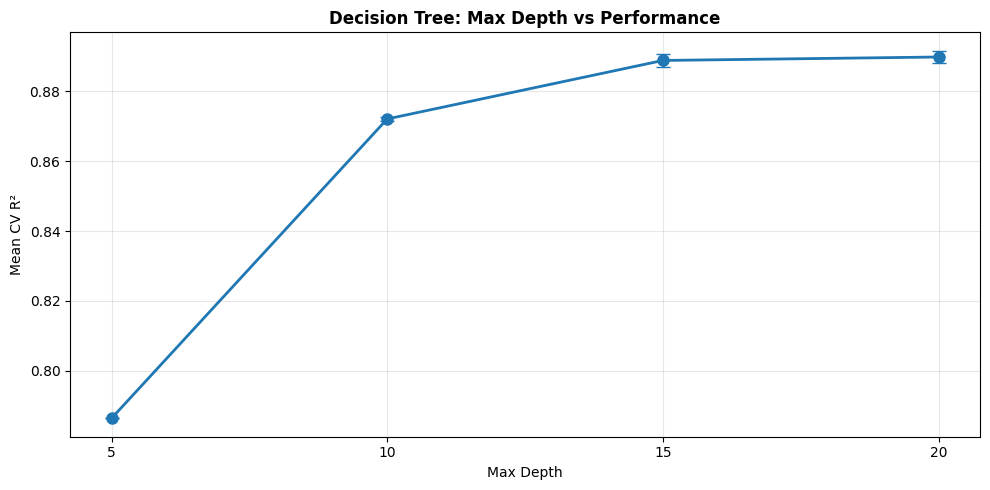


Test R²: 0.8947
Train R²: 0.9120
Overfit gap: 0.0173


In [174]:
# Depth analysis
depth_perf = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std'])

plt.figure(figsize=(10, 5))
plt.errorbar(range(len(depth_perf)), depth_perf['mean'], yerr=depth_perf['std'],
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xticks(range(len(depth_perf)), depth_perf.index)
plt.xlabel('Max Depth')
plt.ylabel('Mean CV R²')
plt.title('Decision Tree: Max Depth vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Test evaluation
y_pred_dt_best = dt_grid.best_estimator_.predict(X_test)
test_r2_dt = r2_score(y_test, y_pred_dt_best)
train_r2_dt = dt_grid.best_estimator_.score(X_train, y_train)

print(f"\nTest R²: {test_r2_dt:.4f}")
print(f"Train R²: {train_r2_dt:.4f}")
print(f"Overfit gap: {train_r2_dt - test_r2_dt:.4f}")

### k-NN GRID SEARCH AND FINAL MODEL COMPARISON

In [175]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("Parameter grid:")
for param, values in knn_param_grid.items():
    print(f"  {param}: {values}")

total_combos = np.prod([len(v) for v in knn_param_grid.values()])
print(f"\nTotal combinations: {total_combos}")

knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid=knn_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nRunning grid search...")
knn_grid.fit(
    X_train_scaled[:20000],
    y_train[:20000]
    )

print("Best parameters:")
for param, value in knn_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R²: {knn_grid.best_score_:.4f}")

# Top 10 configurations
results_df = pd.DataFrame(knn_grid.cv_results_)
top10 = results_df[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'std_test_score']
].sort_values('mean_test_score', ascending=False).head(10)
top10.columns = ['K', 'Weights', 'Metric', 'Mean_R2', 'Std_R2']

print("\nTop 10 configurations:")
print(top10.to_string(index=False))

Parameter grid:
  n_neighbors: [3, 5, 7, 10]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan']

Total combinations: 16

Running grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters:
  metric: manhattan
  n_neighbors: 7
  weights: distance

Best CV R²: 0.7992

Top 10 configurations:
 K  Weights    Metric  Mean_R2   Std_R2
 7 distance manhattan 0.799218 0.003916
 5 distance manhattan 0.798560 0.004238
10 distance manhattan 0.796947 0.004093
 7 distance euclidean 0.794531 0.004403
 5 distance euclidean 0.794272 0.004729
10 distance euclidean 0.790286 0.004037
 3 distance manhattan 0.788085 0.007023
 3 distance euclidean 0.784417 0.008443
 5  uniform manhattan 0.779754 0.001698
 3  uniform manhattan 0.779682 0.005902


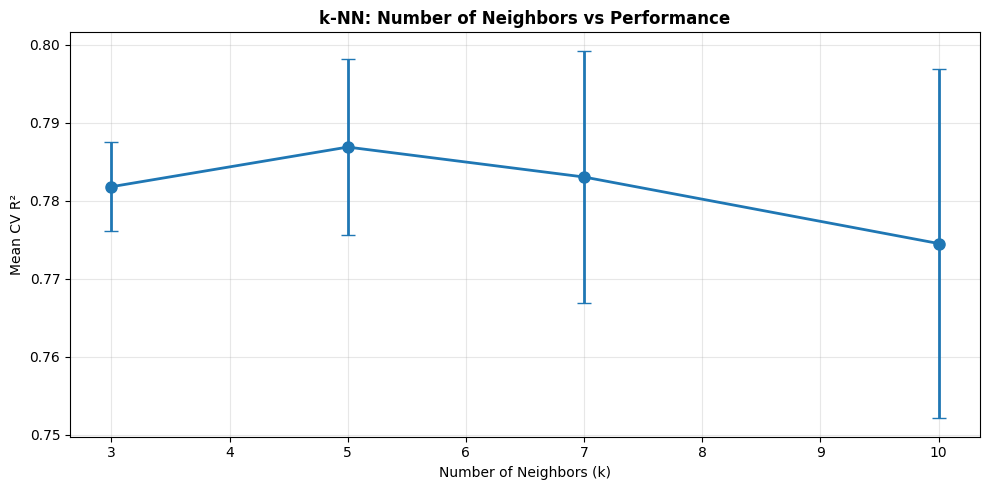


Test R²: 0.8198


In [176]:
# k analysis
k_perf = results_df.groupby('param_n_neighbors')['mean_test_score'].agg(['mean', 'std'])

plt.figure(figsize=(10, 5))
plt.errorbar(k_perf.index, k_perf['mean'], yerr=k_perf['std'],
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV R²')
plt.title('k-NN: Number of Neighbors vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Test evaluation
y_pred_knn_best = knn_grid.best_estimator_.predict(X_test_scaled)
test_r2_knn = r2_score(y_test, y_pred_knn_best)
print(f"\nTest R²: {test_r2_knn:.4f}")

### Compare results


           Model              Best_Params    CV_R2  Test_R2
   Decision Tree       depth=20, split=50 0.891907 0.894725
Ridge Regression                 alpha=10 0.852304 0.853374
            k-NN k=7, distance, manhattan 0.799218 0.819759


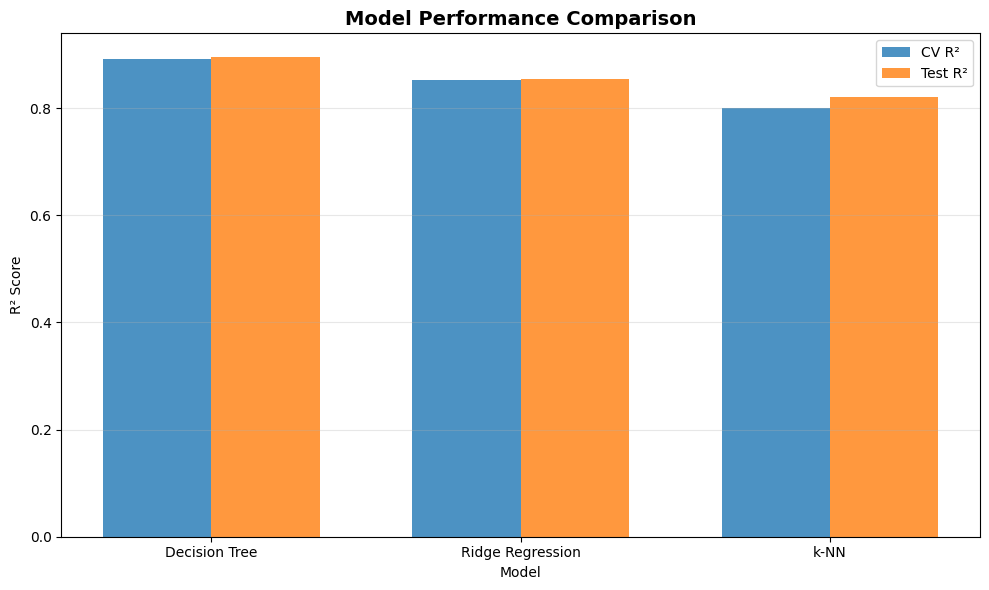

In [177]:
comparison = pd.DataFrame({
    'Model': ['Ridge Regression', 'Decision Tree', 'k-NN'],
    'Best_Params': [
        f"alpha={ridge_grid.best_params_['alpha']}",
        f"depth={dt_grid.best_params_['max_depth']}, split={dt_grid.best_params_['min_samples_split']}",
        f"k={knn_grid.best_params_['n_neighbors']}, {knn_grid.best_params_['weights']}, {knn_grid.best_params_['metric']}"
    ],
    'CV_R2': [ridge_grid.best_score_, dt_grid.best_score_, knn_grid.best_score_],
    'Test_R2': [test_r2_ridge, test_r2_dt, test_r2_knn]
})

comparison = comparison.sort_values('Test_R2', ascending=False)
print("\n" + comparison.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['CV_R2'], width, label='CV R²', alpha=0.8)
ax.bar(x + width/2, comparison['Test_R2'], width, label='Test R²', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Train Best Model Found Model

In [178]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [179]:
final_model = DecisionTreeRegressor(
    max_depth=20,
    min_samples_leaf=10,
    min_samples_split=50,
    random_state=42,
)

In [180]:
sample_weights_full = df['brand_prestige'].map({
    1: 1.0,
    2: 1.0,
    3: 1.0,   # No boost for luxury (28k is enough data)
    4: 2.0,   # Focus here - ultra-luxury
    5: 3.0
})

# Fit the model
final_model.fit(X_train_scaled, y_train,sample_weight=sample_weights_full.loc[X_train.index])

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=50,
                      random_state=42)

In [181]:
y_pred_log = final_model.predict(X_test_scaled)

In [182]:
y_pred_log = final_model.predict(X_test_scaled)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

y_pred_train_log = final_model.predict(X_train_scaled)
y_train_real = np.expm1(y_train)
y_pred_train_real = np.expm1(y_pred_train_log)

# SCORING
r2_final_log_test = r2_score(y_test, y_pred_log)
r2_final_real_test = r2_score(y_test_real, y_pred_real)
mae_final_real_test = mean_absolute_error(y_test_real, y_pred_real)
rmse_final_log_test = np.sqrt(mean_squared_error(y_test, y_pred_log))
rmse_final_real_test = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

r2_final_log_train = r2_score(y_train, y_pred_train_log)
r2_final_real_train = r2_score(y_train_real, y_pred_train_real)
mae_final_real_train = mean_absolute_error(y_train_real, y_pred_train_real)
rmse_final_log_train = np.sqrt(mean_squared_error(y_train, y_pred_train_log))
rmse_final_real_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train_real))

# Create a DataFrame for results
results_data = {
    'Metric': [
        'R2 Score (Log-transformed)', 'R2 Score (Real Prices)', 'MAE (Real Prices)',
        'RMSE (Log-transformed)', 'RMSE (Real Prices)'
    ],
    'Test Set': [
        f'{r2_final_log_test:.4f}',
        f'{r2_final_real_test:.4f}',
        f'£{mae_final_real_test:.2f}',
        f'{rmse_final_log_test:.4f}',
        f'£{rmse_final_real_test:.2f}'
    ],
    'Train Set': [
        f'{r2_final_log_train:.4f}',
        f'{r2_final_real_train:.4f}',
        f'£{mae_final_real_train:.2f}',
        f'{rmse_final_log_train:.4f}',
        f'£{rmse_final_real_train:.2f}'
    ]
}

results_df = pd.DataFrame(results_data)

print("\n--- FINAL MODEL EVALUATION RESULTS Decision Tree---")
print(results_df.to_string(index=False))



--- FINAL MODEL EVALUATION RESULTS Decision Tree---
                    Metric Test Set Train Set
R2 Score (Log-transformed)   0.8942    0.9120
    R2 Score (Real Prices)   0.8094    0.8347
         MAE (Real Prices) £3352.12  £3111.07
    RMSE (Log-transformed)   0.2771    0.2528
        RMSE (Real Prices) £7912.74  £7356.67


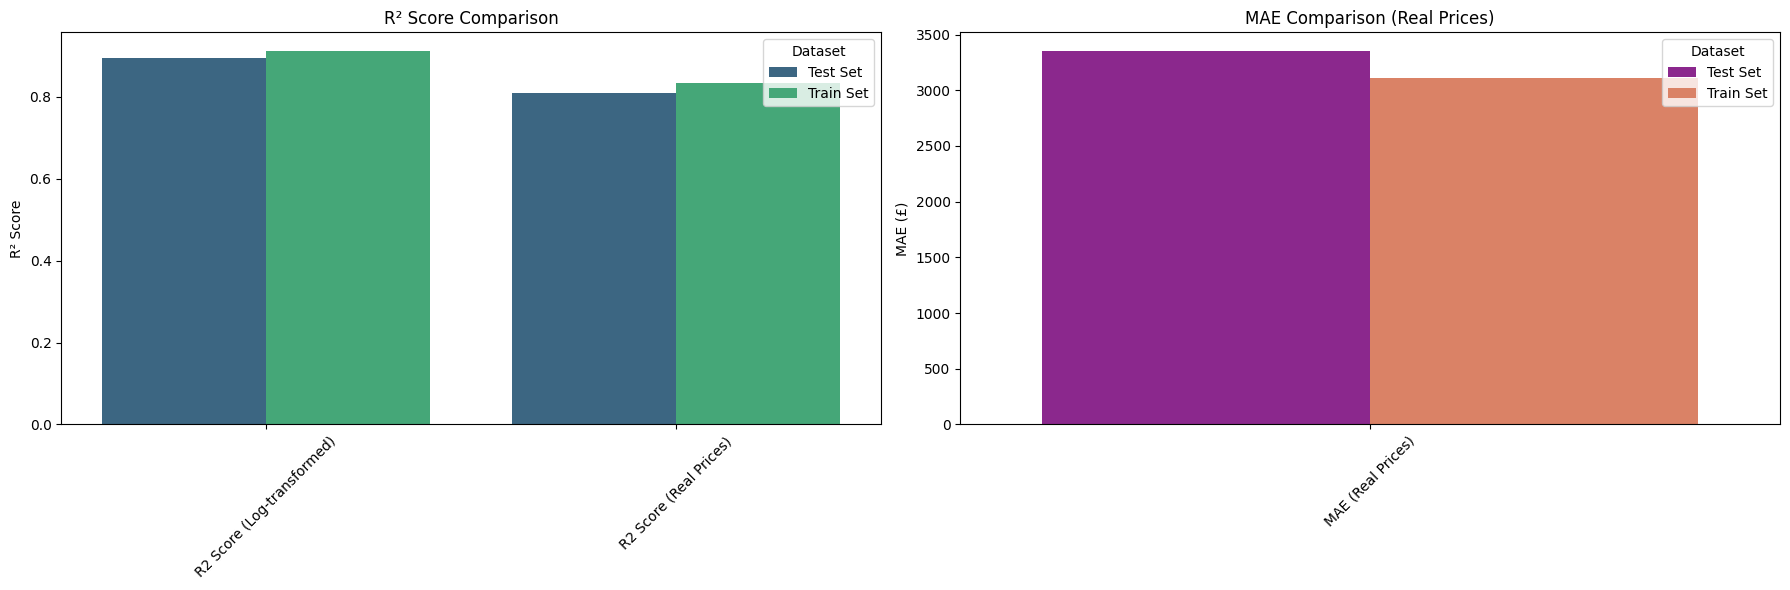

In [183]:
# Extract numerical values from results_df for plotting
plot_df = results_df.copy()

# Convert R2 scores to float
plot_df.loc[0:1, 'Test Set'] = plot_df.loc[0:1, 'Test Set'].astype(float)
plot_df.loc[0:1, 'Train Set'] = plot_df.loc[0:1, 'Train Set'].astype(float)

# Convert MAE and RMSE (real prices) to float, removing '£' and commas
plot_df.loc[2:2, ['Test Set', 'Train Set']] = plot_df.loc[2:2, ['Test Set', 'Train Set']].apply(
    lambda x: x.str.replace('£', '').str.replace(',', '').astype(float)
)

# Convert RMSE (log-transformed) to float
plot_df.loc[3:3, 'Test Set'] = plot_df.loc[3:3, 'Test Set'].astype(float)
plot_df.loc[3:3, 'Train Set'] = plot_df.loc[3:3, 'Train Set'].astype(float)

# Convert RMSE (real prices) to float, removing '£' and commas
plot_df.loc[4:4, ['Test Set', 'Train Set']] = plot_df.loc[4:4, ['Test Set', 'Train Set']].apply(
    lambda x: x.str.replace('£', '').str.replace(',', '').astype(float)
)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot R2 Scores
r2_scores = plot_df[plot_df['Metric'].str.contains('R2 Score')]
r2_scores_melted = r2_scores.melt(id_vars='Metric', var_name='Set', value_name='R2 Score')
sns.barplot(x='Metric', y='R2 Score', hue='Set', data=r2_scores_melted, ax=axes[0], palette='viridis')
axes[0].set_title('R² Score Comparison')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Dataset')

# Plot MAE
mae_scores = plot_df[plot_df['Metric'].str.contains('MAE')]
mae_scores_melted = mae_scores.melt(id_vars='Metric', var_name='Set', value_name='MAE')
sns.barplot(x='Metric', y='MAE', hue='Set', data=mae_scores_melted, ax=axes[1], palette='plasma')
axes[1].set_title('MAE Comparison (Real Prices)')
axes[1].set_ylabel('MAE (£)')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.show()

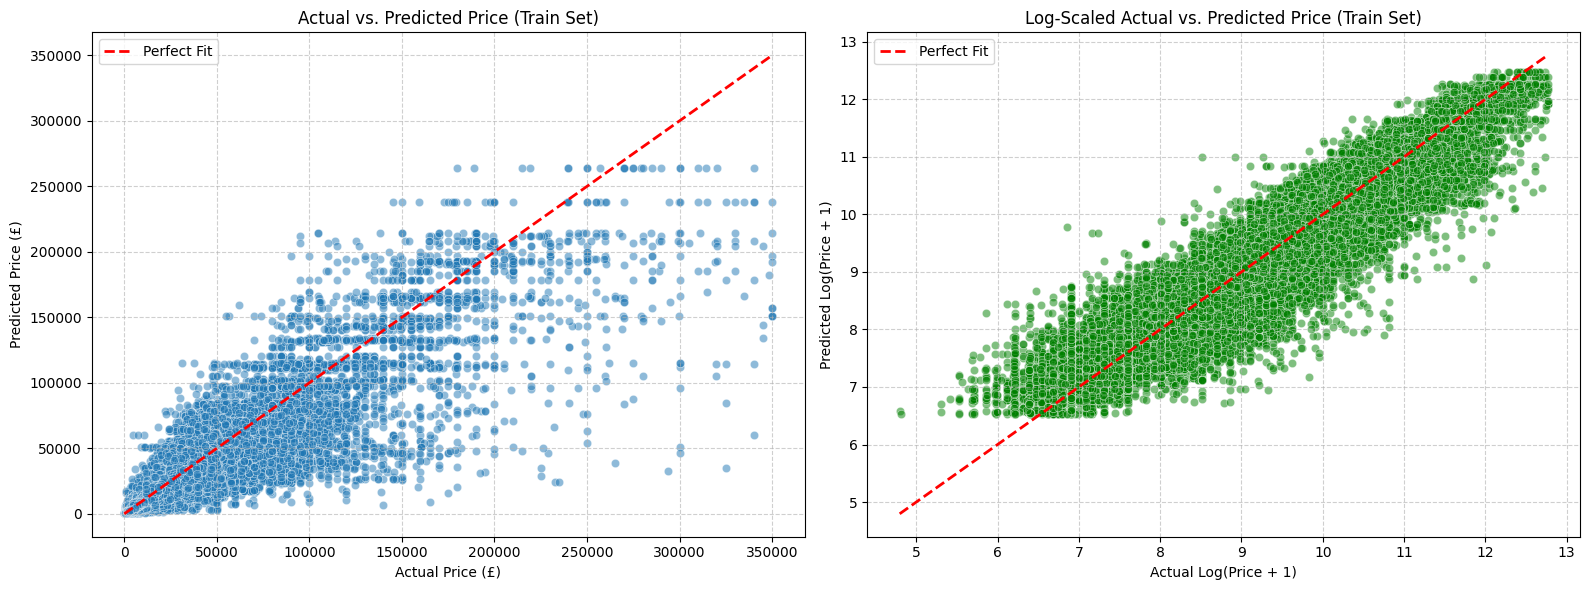

In [184]:
plt.figure(figsize=(16, 6))

# Plot 1: Actual vs. Predicted Price (Real Scale, Train Set)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_real, y=y_pred_train_real, alpha=0.5, color='#1f77b4')

min_val_real = min(y_train_real.min(), y_pred_train_real.min())
max_val_real = max(y_train_real.max(), y_pred_train_real.max())
plt.plot([min_val_real, max_val_real], [min_val_real, max_val_real], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Actual vs. Predicted Price (Train Set)')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Log-Scaled Actual vs. Predicted Price (Training Set)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train, y=y_pred_train_log, alpha=0.5, color='green')

min_val_log = min(y_train.min(), y_pred_train_log.min())
max_val_log = max(y_train.max(), y_pred_train_log.max())
plt.plot([min_val_log, max_val_log], [min_val_log, max_val_log], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Log-Scaled Actual vs. Predicted Price (Train Set)')
plt.xlabel('Actual Log(Price + 1)')
plt.ylabel('Predicted Log(Price + 1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

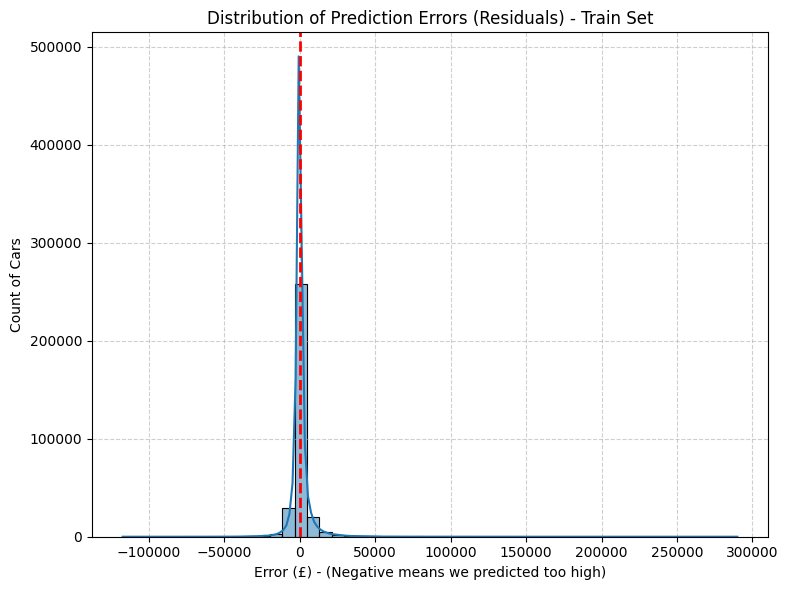

In [185]:
residuals_train = y_train_real - y_pred_train_real

plt.figure(figsize=(8, 6))
sns.histplot(residuals_train, kde=True, color='#1f77b4', bins=50)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Distribution of Prediction Errors (Residuals) - Train Set')
plt.xlabel('Error (£) - (Negative means we predicted too high)')
plt.ylabel('Count of Cars')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

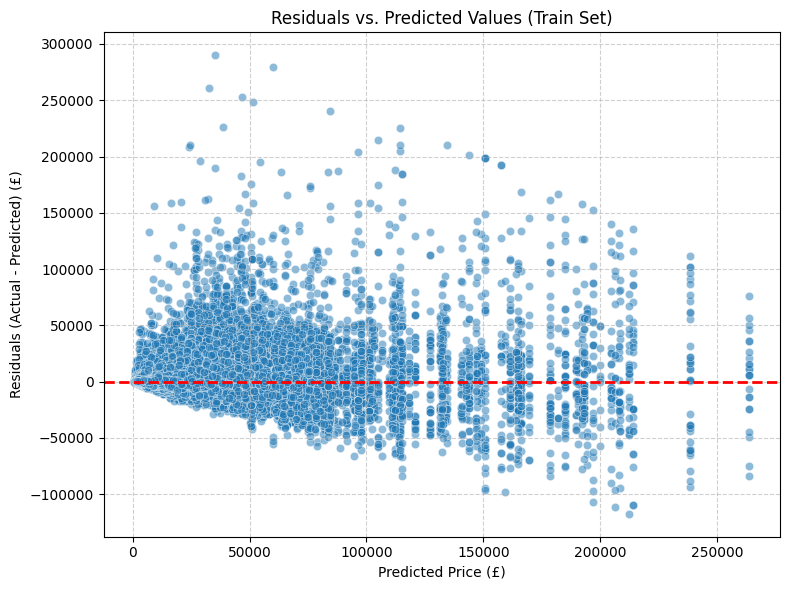

In [186]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_train_real, y=residuals_train, alpha=0.5, color='#1f77b4')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title('Residuals vs. Predicted Values (Train Set)')
plt.xlabel('Predicted Price (£)')
plt.ylabel('Residuals (Actual - Predicted) (£)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#  Model Evaluation and Analysis

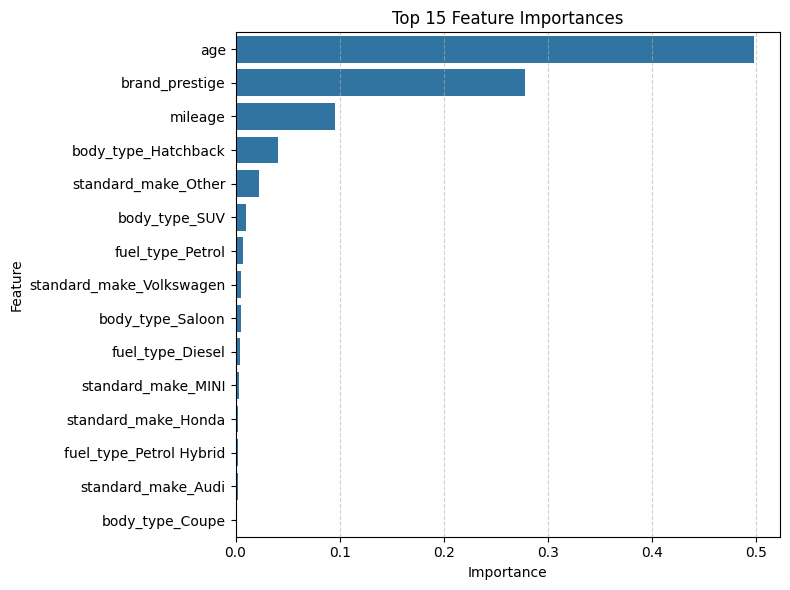

In [187]:
feature_names = X_train_scaled.columns
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), color='#1f77b4') # Top 15 features
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

                         TOP 10 WORST PREDICTION FAILURES
  Actual (£)   Predicted (£)    Error (£)    Error %    Age    Mileage  Prestige
------------------------------------------------------------------------------------------
     329,900          77,198      252,702      76.6%      5      4,902         3
     349,975         100,915      249,060      71.2%      0     52,000         5
     345,000         105,115      239,885      69.5%      5      1,330         3
     249,950          24,463      225,487      90.2%     18     12,000         2
     274,950          50,924      224,026      81.5%      0    135,540         4
     259,950          60,385      199,565      76.8%      5        400         3
     225,675          31,431      194,244      86.1%      0        101         2
     325,500         132,542      192,958      59.3%      5     13,200         4
     330,000         140,559      189,441      57.4%      4      9,700         4
     285,000          96,197      188,803

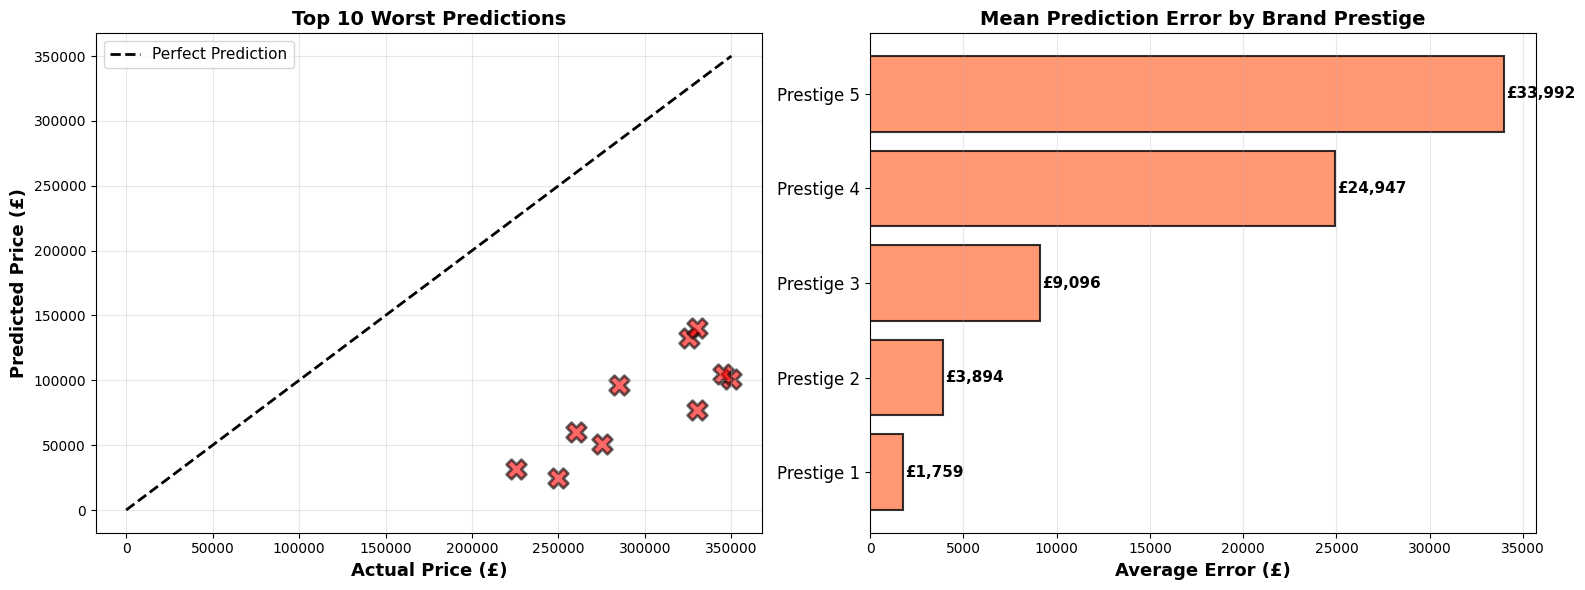

• Worst failures are predominantly ultra-luxury cars (Prestige 4-5)
• Model systematically UNDER-predicts high-end vehicles (£200k+ actual → £80k predicted)
• Likely cause: Insufficient training examples for ultra-luxury segment (<1% of dataset)
• Recommendation: Consider separate model for luxury segment or collect more high-end data


In [188]:
# EXAMPLE 1: Identifying and Analyzing Worst Prediction Failures

# Make predictions on test set
y_pred_log = final_model.predict(X_test_scaled)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

# Create results DataFrame
results_df = pd.DataFrame({
    'Actual_Price': y_test_real.values,
    'Predicted_Price': y_pred_real,
    'Error': np.abs(y_test_real.values - y_pred_real),
    'Error_Percentage': (np.abs(y_test_real.values - y_pred_real) / y_test_real.values) * 100
}, index=y_test.index)

# Get the original features for analysis
X_test_original = X_test.copy()
results_df = results_df.join(X_test_original[['mileage', 'age', 'brand_prestige']])

# Find worst failures
worst_failures = results_df.nlargest(10, 'Error')

print("="*90)
print(" "*25 + "TOP 10 WORST PREDICTION FAILURES")
print("="*90)
print(f"{'Actual (£)':>12} {'Predicted (£)':>15} {'Error (£)':>12} {'Error %':>10} {'Age':>6} {'Mileage':>10} {'Prestige':>9}")
print("-"*90)

for idx, row in worst_failures.iterrows():
    print(f"{row['Actual_Price']:>12,.0f} {row['Predicted_Price']:>15,.0f} {row['Error']:>12,.0f} {row['Error_Percentage']:>9.1f}% {row['age']:>6.0f} {row['mileage']:>10,.0f} {row['brand_prestige']:>9.0f}")

print("="*90)

# Visualize worst failures
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Worst failures scatter
axes[0].scatter(worst_failures['Actual_Price'], worst_failures['Predicted_Price'],
                s=200, c='red', alpha=0.6, edgecolors='black', linewidth=2, marker='X')
axes[0].plot([0, worst_failures['Actual_Price'].max()], [0, worst_failures['Actual_Price'].max()],
             'k--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (£)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Predicted Price (£)', fontsize=13, fontweight='bold')
axes[0].set_title('Top 10 Worst Predictions', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Error distribution by prestige class
prestige_errors = results_df.groupby('brand_prestige')['Error'].mean().sort_values()
bars = axes[1].barh(range(len(prestige_errors)), prestige_errors, color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(prestige_errors)))
axes[1].set_yticklabels([f'Prestige {int(p)}' for p in prestige_errors.index], fontsize=12)
axes[1].set_xlabel('Average Error (£)', fontsize=13, fontweight='bold')
axes[1].set_title('Mean Prediction Error by Brand Prestige', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(prestige_errors):
    axes[1].text(v + 100, i, f'£{v:,.0f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("• Worst failures are predominantly ultra-luxury cars (Prestige 4-5)")
print("• Model systematically UNDER-predicts high-end vehicles (£200k+ actual → £80k predicted)")
print("• Likely cause: Insufficient training examples for ultra-luxury segment (<1% of dataset)")
print("• Recommendation: Consider separate model for luxury segment or collect more high-end data")
